In [1]:
import pandas as pd
import numpy as np
import time
import os
import cv2
from multiprocessing import Pool
import matplotlib.pyplot as plt
import random

In [2]:
DATA_PATH = 'data/'

In [4]:
#data = pd.DataFrame(columns=['Weight', 'Image', 'Flattened Image', 'Scale Timestamp', 'Image Timestamp', 'Time Offset'])
lst = []
index = 1
for fn in os.listdir(DATA_PATH + "csv/"):
    if os.path.isfile(DATA_PATH + "csv/" + fn):
        if (fn.endswith(".csv")):            
            print("Reading " + DATA_PATH + "csv/" + fn)
            data_current = pd.read_csv(DATA_PATH + "csv/" + fn, delimiter=';')
            # the csv file ends with a delimiter sign which gets interpreted as column therefore we omit it manually
            data_current = data_current.drop(data_current.columns[6], axis=1)
            # add participant column to identify data point to unique participant id
            data_current['Participant'] = index
            # also add the participants data to the data points
            info = fn.split(".")[0].split("_")
            data_current['Gender'] = info[1]
            data_current['Occupation'] = info[2]
            data_current['Age'] = info[3]
            lst.append(data_current)
            index = index + 1


Reading data/csv/19e98630-e8a6-4ba1-8ddb-8d8bf4eb9e21_Male_Student_23.csv
Reading data/csv/6db7fca4-ede0-485f-b4cb-29085f4728c5_Female_Student_22.csv
Reading data/csv/24944901-a831-42fe-a2db-47b76d485725_Male_Other_24.csv
Reading data/csv/5456008e-9eb7-40a4-ad88-04001be5077b_Male_Student_25.csv
Reading data/csv/d1edf3aa-c838-443b-82b4-6b119b8cca72_Male_Student_24.csv
Reading data/csv/7808c738-558d-4644-add1-0b2affe61ffe_Female_Student_23.csv
Reading data/csv/f6f941aa-78e8-4723-999c-b2d0e2f6d1ed_Male_Student_23.csv
Reading data/csv/7a79ea49-cb85-4acb-9d6b-c0ab35b5fc8f_Male_Student_23.csv
Reading data/csv/b824bf10-c9e9-41c0-acca-48382ba899ce_Male_Student_25.csv
Reading data/csv/0770d6ae-80c7-4874-bcd3-18b9dcc0ad2c_Male_Student_22.csv
Reading data/csv/5fdfd2ac-7403-4ab2-a2ca-0e31f2cbe6d0_Male_Student_26.csv
Reading data/csv/71c129f8-917d-4557-a3ba-8fd341580dfc_Male_Student_22.csv
Reading data/csv/b8b3115b-d3aa-43f1-aa72-70e7bb7339bb_Male_Student_22.csv
Reading data/csv/9f8de787-0638-4bc0-

In [5]:
df = pd.concat(lst)
df.head()

,Weight,Image,Flattened Image,Scale Timestamp,Image Timestamp,Time Offset,Participant,Gender,Occupation,Age
0,110,"[[-2, -28, -1, 1, -1, -1, -1, 0, 0, 0, 0, -2, ...","[-2, -28, -1, 1, -1, -1, -1, 0, 0, 0, 0, -2, 1...",1.528834e+12,1.528834e+12,36.0,1,Male,Student,23
1,8,"[[-2, -28, -1, 1, -1, -1, -1, 0, 0, 0, 0, -2, ...","[-2, -28, -1, 1, -1, -1, -1, 0, 0, 0, 0, -2, 1...",1.528834e+12,1.528834e+12,12.0,1,Male,Student,23
2,2,"[[-2, -28, -1, 1, -1, -1, -1, 0, 0, 0, 0, -2, ...","[-2, -28, -1, 1, -1, -1, -1, 0, 0, 0, 0, -2, 1...",1.528834e+12,1.528834e+12,55.0,1,Male,Student,23
3,2,"[[-2, -28, -1, 1, -1, -1, -1, 0, 0, 0, 0, -2, ...","[-2, -28, -1, 1, -1, -1, -1, 0, 0, 0, 0, -2, 1...",1.528834e+12,1.528834e+12,82.0,1,Male,Student,23
4,2,"[[-2, -28, -1, 1, -1, -1, -1, 0, 0, 0, 0, -2, ...","[-2, -28, -1, 1, -1, -1, -1, 0, 0, 0, 0, -2, 1...",1.528834e+12,1.528834e+12,3.0,1,Male,Student,23


In [6]:
%%time
# convert the collected matrices to numpy arrays
raw_matrix = df['Flattened Image'].apply(lambda x:x.replace("[","").replace("]",""))
df.Image = raw_matrix.apply(lambda x: np.fromstring(x, sep=",", dtype=np.int32))
del df['Flattened Image']

CPU times: user 1.76 s, sys: 226 ms, total: 1.99 s
Wall time: 1.99 s


In [7]:
print("Removed %i invalid entries" % len(df[df.Image.map(len) != 405]))
df = df[df.Image.map(len) == 405]

df = df[~(df["Time Offset"].isna())]
df.Weight = pd.to_numeric(df.Weight)
df.Age = pd.to_numeric(df.Age).astype(int)


Removed 2 invalid entries


In [8]:
len(df)

115134

In [9]:
df = df[(df["Time Offset"] < 80) & (df.Weight > 0)]

In [10]:
115134-len(df)

7424

In [11]:
df.Image = df.Image.apply(lambda x: x.reshape(27,15))
df.Image = df.Image.apply(lambda x: x.clip(min=0, max=255))
df.Image = df.Image.apply(lambda x: x.astype(np.uint8))

In [12]:
df["ImageSum"] = df.Image.apply(lambda x: np.sum(x))

In [13]:
def detect_blobs(image):
    #image = image.reshape(27, 15)
    large = np.ones((29,17), dtype=np.uint8)
    large[1:28,1:16] = image
    temp, thresh = cv2.threshold(cv2.bitwise_not(large), 180, 255, cv2.THRESH_BINARY)
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [a for a in contours if cv2.contourArea(a) > 5 and cv2.contourArea(a) < 255]
    lst  = []
    count = 0
    if len(contours) > 0:
        max_contour = max(contours, key=lambda a: cv2.contourArea(a))
        xmax, ymax = np.max(max_contour.reshape(len(max_contour),2), axis=0)
        xmin, ymin = np.min(max_contour.reshape(len(max_contour),2), axis=0)
        #croped_im = np.zeros((27,15))
        blob = large[max(ymin - 1, 0):min(ymax + 1, large.shape[0]),max(xmin - 1, 0):min(xmax + 1, large.shape[1])]
        # THIS WAS WRONG!
        #blob = large[max(ymin - 1, 0):min(ymax + 1, image.shape[0]),max(xmin - 1, 0):min(xmax + 1, image.shape[1])]
        lst.append(blob)
        count = count + 1
    else:
        return (0, np.zeros((29,17)), 0, 0)
    
    return (count, [lst], xmax-xmin, ymax-ymin) 

In [14]:
%%time
pool = Pool(8)
temp_blobs = pool.map(detect_blobs, df.Image)
pool.close()

CPU times: user 1.38 s, sys: 373 ms, total: 1.75 s
Wall time: 2.13 s


In [15]:
df["BlobCount"] = [a[0] for a in temp_blobs]
df["BlobImages"] = [a[1] for a in temp_blobs]
df["BlobW"] = [a[2] for a in temp_blobs]
df["BlobH"] = [a[3] for a in temp_blobs]
df["BlobArea"] = df["BlobW"]* df["BlobH"]
print(len(df[df.BlobCount > 0]))
df = df[df.BlobCount > 0]
print(len(df))

82526
82526


In [16]:
df.BlobArea.describe().round(1)

count    82526.0
mean        18.4
std          4.1
min          8.0
25%         16.0
50%         16.0
75%         20.0
max         48.0
Name: BlobArea, dtype: float64

In [17]:
# Only if one Blob is in data
df.BlobImages = df.BlobImages.apply(lambda x: x[0][0])

In [18]:
df["BlobSum"] = df.BlobImages.apply(lambda x: np.sum(x))

In [19]:
df = df[df.BlobSum >= 255*4]

Text(0, 0.5, 'Sample Count')

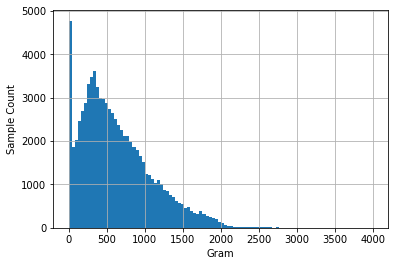

In [20]:
df[(df.Weight<4000)].Weight.hist(bins = 100, range=(0,4000))#, log=True,)
plt.xlabel("Gram")
plt.ylabel("Sample Count")

In [21]:
len(df[df.Weight > 2000]) / len(df)

0.006825304413531692

In [22]:
df = df[df.Weight < 2000]

In [23]:
df["Noise"] = 0

In [24]:
def addNoise (image):
    mu, sigma = 0, 1.5 # mean and standard deviation
    ran = np.random.normal(mu, sigma, image.shape[0] * image.shape[1]).reshape((image.shape[0], image.shape[1])).round()
    return image + ran

In [26]:
lst = [0]
binWidth = 50
binCount = 7000
while len(lst) > 0:
    lst = []
    for i in range (0,2500,binWidth):
        dfY = df[(df.Weight >= i) & (df.Weight < i+binWidth)]
        if ((len(dfY) > 0) & (len(dfY) < binCount)):
            if(len(dfY) > binCount-len(dfY)):
                dfY = dfY.sample(frac=1)[:binCount-len(dfY)]
            dfX = dfY.copy(deep=True)
            dfX.BlobImages = dfX.BlobImages.apply(lambda x: addNoise(x))
            dfX.BlobImages = dfX.BlobImages.apply(lambda x: x.clip(min=0, max=255))
            dfX.Noise = dfX.Noise + 1
            lst.append(dfX)
    if (len(lst)>0):
        df = df.append(lst)

In [28]:
len(df)

280000

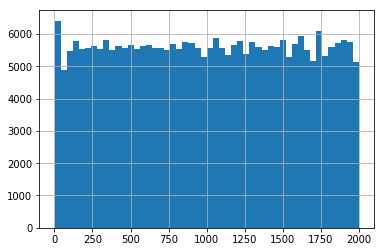

In [27]:
df.Weight.hist(bins = binWidth)

In [29]:
df["Version"] = "Normal"
dfFlipped = df.copy(deep=True)
dfFlipped.BlobImages = dfFlipped.BlobImages.apply(lambda x: np.flipud(x))
dfFlipped["Version"] = "FlippedUD"
df = df.append(dfFlipped)
dfFlipped = df.copy(deep=True)
dfFlipped.BlobImages = dfFlipped.BlobImages.apply(lambda x: np.fliplr(x))
dfFlipped["Version"] = "FlippedLR"
df = df.append(dfFlipped)

In [30]:
len(df)

1120000

In [58]:
def pasteToEmpty (blob):
    croped_im = np.zeros((27,15))
    croped_im[0:blob.shape[0],0:blob.shape[1]] = blob
    return croped_im

In [59]:
df.BlobImages = df.BlobImages.apply(lambda x: pasteToEmpty(x))

In [60]:
df.groupby("Participant").mean().Age.describe()

count    20.000000
mean     23.300000
std       1.719853
min      19.000000
25%      22.000000
50%      23.000000
75%      24.000000
max      27.000000
Name: Age, dtype: float64

In [61]:
df.groupby("Participant").Gender.unique().value_counts()

[Male]      15
[Female]     5
Name: Gender, dtype: int64

In [62]:
df.groupby("Participant").Occupation.unique().value_counts()

[Student]    19
[Other]       1
Name: Occupation, dtype: int64

In [63]:
del df["BlobCount"]
del df["Image"]
del df["Age"]
del df["Gender"]
del df["Occupation"]
del df["Scale Timestamp"]

In [ ]:
[15, 12, 19, 11, 3, 5, 14, 18, 2, 7, 16, 20, 17, 13, 1, 6, 10, 4, 8, 9]

In [69]:
lst = list(range(1, 21))
SEED = 42#448
random.seed(SEED)
random.shuffle(lst)
lst

[20, 6, 15, 5, 10, 14, 16, 19, 7, 13, 18, 11, 2, 12, 3, 17, 8, 9, 1, 4]

In [76]:
df["Set"] = "Test"
df.loc[df.Participant.isin(lst[0: 15]), "Set"] = "Train"

In [77]:
df.head()

,Weight,Image Timestamp,Time Offset,Participant,ImageSum,BlobImages,BlobW,BlobH,BlobArea,BlobSum,Noise,Version,Set
13,2,1.528834e+12,34.0,1,1917,"[[2.0, 2.0, 9.0, 7.0, 2.0, 0.0, 0.0, 0.0, 0.0,...",3,3,9,1072,0,Normal,Test
14,23,1.528834e+12,50.0,1,2096,"[[0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3,4,12,1171,0,Normal,Test
15,126,1.528834e+12,43.0,1,1661,"[[0.0, 0.0, 1.0, 4.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",4,4,16,1305,0,Normal,Test
16,231,1.528834e+12,12.0,1,1465,"[[0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4,4,16,1321,0,Normal,Test
17,308,1.528834e+12,37.0,1,1465,"[[0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4,4,16,1321,0,Normal,Test


In [ ]:
df.to_pickle(DATA_PATH + "data.pkl")